

# **Redes Neuronales Convolucionales**



In [ ]:
###################
#Separamos los datos en 3 conjuntos de datos, un 80% train, 10% test y 10% validacion.
import splitfolders
splitfolders.ratio('/content/clasificacion-radiografias/dataset', output="output", seed=1337, ratio=(.8, 0.1,0.1))

train_path = '/content/output/train'
test_path = '/content/output/test'
val_path = '/content/output/val'

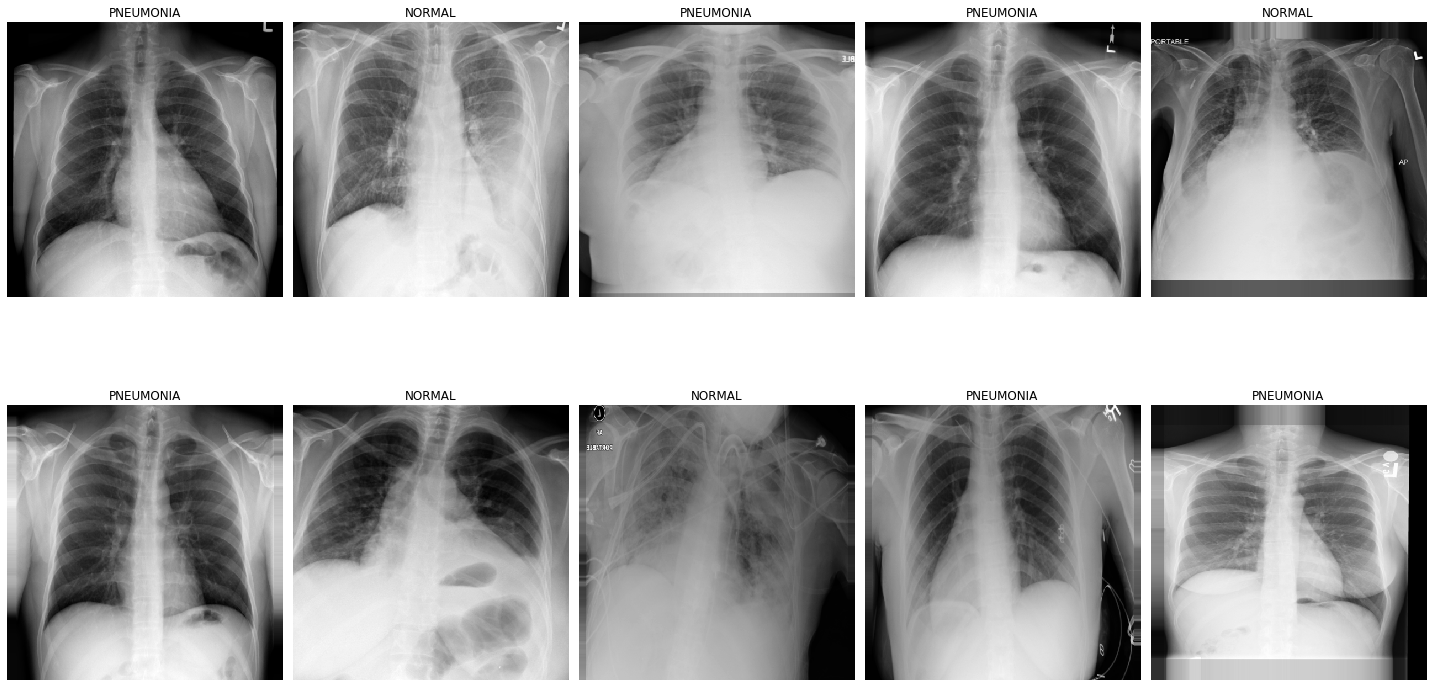

In [ ]:
import matplotlib.pyplot as plt


plt.figure(figsize=(20, 12))
for i in range(0, 10):
    plt.subplot(2, 5, i+1)
    for X_batch, Y_batch in train:
        image = X_batch[0]        
        dic = {0:'NORMAL', 1:'PNEUMONIA'}
        plt.title(dic.get(Y_batch[0]))
        plt.axis('off')
        plt.imshow(np.squeeze(image),cmap='gray',interpolation='nearest')
        break
plt.tight_layout()
plt.show()

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img

image_gen = ImageDataGenerator(
                                   rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True,
                              
                               )  

test_data_gen = ImageDataGenerator(rescale = 1./255)



train = image_gen.flow_from_directory(
    train_path,
    target_size=(500, 500),
    color_mode='grayscale',
    class_mode='binary',
    batch_size=16
                                      )

test = test_data_gen.flow_from_directory(
      test_path,
      target_size=(500, 500),
      color_mode='grayscale',shuffle=False,
      class_mode='binary',
      batch_size=16
      )
valid = test_data_gen.flow_from_directory(
      val_path,
      target_size=(500, 500),
      color_mode='grayscale',
      class_mode='binary', 
      batch_size=16
      )

###########

Found 800 images belonging to 2 classes.
Found 100 images belonging to 2 classes.
Found 100 images belonging to 2 classes.


In [ ]:
featurewise_center=False,  # set input mean to 0 over the dataset
samplewise_center=False,  # set each sample mean to 0
featurewise_std_normalization=False,  # divide inputs by std of the dataset
samplewise_std_normalization=False,  # divide each input by its std
zca_whitening=False,  # apply ZCA whitening

rotation_range = 15,  # randomly rotate images in the range (degrees, 0 to 180)
zoom_range = 0.2, # Randomly zoom image 
width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
horizontal_flip = True,  # randomly flip images
vertical_flip=False,# randomly flip images
shear_range=0.2,
brightness_range=(1.2, 1.5)

In [ ]:
from tensorflow.keras.models import Sequential,load_model,save_model
from tensorflow.keras.layers import Dense,Conv2D,Flatten,MaxPooling2D
from tensorflow.keras.callbacks import EarlyStopping,ReduceLROnPlateau

In [ ]:

classifier = Sequential()

classifier.add(Conv2D(32, (3, 3), activation="relu", input_shape=(500, 500, 1)))
classifier.add(MaxPooling2D(pool_size = (2, 2)))

classifier.add(Conv2D(32, (3, 3), activation="relu", input_shape=(500, 500, 1)))
classifier.add(MaxPooling2D(pool_size = (2, 2)))

classifier.add(Conv2D(32, (3, 3), activation="relu", input_shape=(500, 500, 1)))
classifier.add(MaxPooling2D(pool_size = (2, 2)))

classifier.add(Conv2D(64, (3, 3), activation="relu", input_shape=(500, 500, 1)))
classifier.add(MaxPooling2D(pool_size = (2, 2)))

classifier.add(Conv2D(64, (3, 3), activation="relu", input_shape=(500, 500, 1)))
classifier.add(MaxPooling2D(pool_size = (2, 2)))

classifier.add(Flatten())

classifier.add(Dense(activation = 'relu', units = 128))
classifier.add(Dense(activation = 'relu', units = 64))
classifier.add(Dense(activation = 'sigmoid', units = 1))


classifier.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

In [ ]:
classifier.summary()

Model: "sequential_21"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_63 (Conv2D)          (None, 498, 498, 32)      320       
                                                                 
 max_pooling2d_63 (MaxPoolin  (None, 249, 249, 32)     0         
 g2D)                                                            
                                                                 
 conv2d_64 (Conv2D)          (None, 247, 247, 32)      9248      
                                                                 
 max_pooling2d_64 (MaxPoolin  (None, 123, 123, 32)     0         
 g2D)                                                            
                                                                 
 conv2d_65 (Conv2D)          (None, 121, 121, 32)      9248      
                                                                 
 max_pooling2d_65 (MaxPoolin  (None, 60, 60, 32)     

In [ ]:
#fit model

early = EarlyStopping(monitor="val_loss", 
                      mode="min", 
                      patience=3)

learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss', patience = 2, verbose=1,factor=0.3, min_lr=0.000001)

callbacks_list = [ early, learning_rate_reduction]

In [ ]:
from sklearn.utils.class_weight import compute_class_weight
weights = compute_class_weight(class_weight='balanced',
                               classes = np.unique(train.classes),
                               y = train.classes)
cw = dict(zip( np.unique(train.classes), weights))
print(cw)


{0: 1.0, 1: 1.0}


In [ ]:
np.unique(train.classes)

array([0, 1], dtype=int32)

In [ ]:
classifier.fit(train,epochs=8, validation_data=valid, class_weight=cw, callbacks=callbacks_list)


Epoch 1/8
50/50 [==============================] - 242s 5s/step - loss: 0.5577 - accuracy: 0.7237 - val_loss: 0.5667 - val_accuracy: 0.7200 - lr: 9.0000e-05
Epoch 2/8
50/50 [==============================] - 241s 5s/step - loss: 0.5608 - accuracy: 0.7138 - val_loss: 0.5651 - val_accuracy: 0.7200 - lr: 9.0000e-05
Epoch 3/8
50/50 [==============================] - 242s 5s/step - loss: 0.5488 - accuracy: 0.7200 - val_loss: 0.5789 - val_accuracy: 0.6900 - lr: 9.0000e-05
Epoch 4/8
50/50 [==============================] - ETA: 0s - loss: 0.5606 - accuracy: 0.7175
Epoch 4: ReduceLROnPlateau reducing learning rate to 2.700000040931627e-05.
50/50 [==============================] - 241s 5s/step - loss: 0.5606 - accuracy: 0.7175 - val_loss: 0.5706 - val_accuracy: 0.7000 - lr: 9.0000e-05
Epoch 5/8
50/50 [==============================] - 242s 5s/step - loss: 0.5575 - accuracy: 0.7113 - val_loss: 0.5704 - val_accuracy: 0.7000 - lr: 2.7000e-05


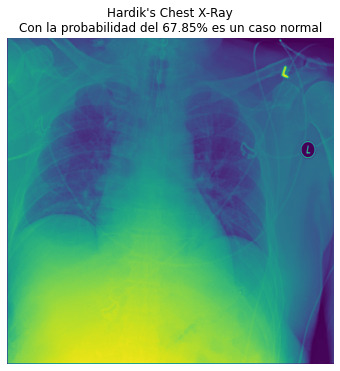

In [ ]:
# Subimos una foto nueva para ver si predice bien, en este caso es una normal.
hardik_path = '/content/normal496.png'

from tensorflow.keras.preprocessing import image

hardik_img = image.load_img(hardik_path, target_size=(500, 500),color_mode='grayscale')

# Preprocessing the image
pp_hardik_img = image.img_to_array(hardik_img)
pp_hardik_img = pp_hardik_img/255
pp_hardik_img = np.expand_dims(pp_hardik_img, axis=0)

#predict
hardik_preds= classifier.predict(pp_hardik_img)

#print
plt.figure(figsize=(6,6))
plt.axis('off')
if hardik_preds>= 0.5: 
    out = ('Con la probabilidad del {:.2%} es un caso de Pneumonia'.format(hardik_preds[0][0]))
    
else: 
    out = ('Con la probabilidad del {:.2%} es un caso normal'.format(1-hardik_preds[0][0]))
    

plt.title("Hardik's Chest X-Ray\n"+out)  
plt.imshow(np.squeeze(pp_hardik_img))
plt.show()